In [100]:
import pandas as pd
import tensorflow as tf
from scikeras.wrappers import KerasClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, log_loss, roc_curve,precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
import warnings
import seaborn as sns

In [3]:
#Read initial data
file_path='rtfDataSet.csv'
df = pd.read_csv(file_path)
print(df.head())

       0      1      2      3      4      5      6      7      8      9  ...  \
0 -0.536  0.292 -0.684  0.123 -0.118  0.346 -0.308 -0.113  0.401 -0.399  ...   
1 -0.496 -0.298 -0.529  0.073 -0.072  0.107 -0.316 -0.066 -0.168 -0.099  ...   
2  0.008 -0.031 -0.240  0.178 -0.120  0.317 -0.481  0.031 -0.077  0.063  ...   
3 -0.188 -0.180 -0.062 -0.104 -0.136 -0.061 -0.216 -0.143  0.068 -0.189  ...   
4  0.038  0.155 -0.203 -0.088 -0.084 -0.164 -0.145 -0.168  0.008  0.143  ...   

      61     62     63     64     65     66     67     68     69  label  
0 -0.135 -0.063 -0.410 -0.223 -0.599 -0.136 -0.329 -0.132 -0.266      0  
1  0.189  0.007 -0.362 -0.151 -0.338 -0.031 -0.159 -0.097 -0.131      0  
2 -0.035  0.101 -0.098 -0.172 -0.290  0.033 -0.342 -0.321 -0.238      0  
3  0.146 -0.145 -0.527 -0.292 -0.663 -0.078 -0.194 -0.151 -0.268      0  
4  0.019 -0.084  0.164 -0.165 -0.126 -0.112  0.029 -0.138  0.148      1  

[5 rows x 71 columns]


In [4]:
#Reduce to sets and normalized
set_2=[2, 5, 9, 10, 16, 21, 28, 34, 38, 48, 49, 55, 61, 62, 64]
set_3=[1, 2, 7, 8, 9, 10, 19, 23, 28, 34, 35, 36, 42, 44, 45, 47, 48, 49, 53, 55, 56, 57, 58, 63, 64, 65, 67]
set_4=[0,1,2,3,6,9,12,14,15,16,17,19,22,23,26,27,29,31,33,34,35,38,41,44,45,47,50,51,54,55,57,58,65,66,67]

reduced_df_2=df.iloc[:,set_2]
reduced_df_3=df.iloc[:,set_3]
reduced_df_4=df.iloc[:,set_4]
y = df.iloc[:, -1]

scaler = MinMaxScaler()

reduced_df_2 = scaler.fit_transform(reduced_df_2)
reduced_df_3 = scaler.fit_transform(reduced_df_3)
reduced_df_4 = scaler.fit_transform(reduced_df_4)


#Array of sets
reduced_array=[reduced_df_2,reduced_df_3,reduced_df_4]

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(reduced_df_2, y, test_size=0.2, random_state=42)
X_train2, X_val2, y_train2, y_val2 = train_test_split(reduced_df_3, y, test_size=0.2, random_state=42)
#X_train2, X_val2, y_train2, y_val2 = train_test_split(X_amigo, y, test_size=0.2, random_state=42)

### Nuevo Gridsearch

In [133]:
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner import HyperParameters

# Define the search space for hyperparameters
hp = HyperParameters()
hp.Choice('learning_rate', values=[0.1, 0.3, 0.5])
hp.Int('neurons', min_value=5, max_value=20, step=5)
hp.Choice('activation', values=['relu', 'sigmoid', 'linear'])
hp.Int('num_layers', min_value=1, max_value=5)  # Hyperparameter for the number of layers

# Define your input shape based on your data
input_shape = (X_train.shape[1],)

# Create a function to build the Keras model
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))

    for _ in range(hp.get('num_layers')):
        model.add(keras.layers.Dense(
            units=hp.Int('neurons', min_value=5, max_value=20, step=5),
            activation=hp.Choice('activation', ['relu', 'sigmoid', 'linear']), 
            kernel_regularizer=keras.regularizers.l1_l2(
                l1=hp.Choice('l1', [0.001, 0.0001, 0.005, 0.0045]),  # L1 regularization
                l2=hp.Choice('l2', [0.001, 0.0001, 0.005, 0.0045])  # L2 regularization
        )))
      

    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.005, 0.1, 0.3, 0.5])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize the tuner (Random Search in this case)
tuner = RandomSearch(
    build_model, objective='val_accuracy', max_trials=70, hyperparameters=hp)

# Perform the hyperparameter search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:", best_hyperparameters)

# Train the best model with the entire training dataset
best_model.fit(X_train, y_train, epochs=10, batch_size=32)

Reloading Tuner from ./untitled_project/tuner0.json


ValueError: Received incompatible tensor with shape (70, 15) when attempting to restore variable with shape (15, 15) and name dense/kernel:0.

In [134]:
mlp = MLPClassifier()

# Define the parameter grid to search
param_grid = {
    'hidden_layer_sizes': [(5), (5,5), (5,5,5), (5,5,5,5),(5,5,5,5,5),
                           (10), (10,10), (10,10,10), (10,10,10,10),(10,10,10,10,10),
                           (15), (15,15), (15,15,15), (15,15,15,15),(15,15,15,15,15),
                           (20), (20,20), (20,20,20), (20,20,20,20),(20,20,20,20,20),
                           (30), (30,30), (30,30,30), (30,30,30,30),(30,30,30,30,30),
                           (40), (40,40), (40,40,40), (40,40,40,40),(40,40,40,40,40),
                           ],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'alpha': [0.1,0.001, 0.0001],
    'beta_1':[0.1,0.2, 0.5,0.6],
    'beta_2':[0.1,0.2, 0.5,0.6],
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(mlp, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Test Accuracy:", accuracy)

KeyboardInterrupt: 

## Model 1

In [124]:
warnings.filterwarnings("ignore")
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
counter = 1
epochs = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
learning_rate_now=0.1
array_accuracy_set = []
array_precision_set=[]
array_recall_set=[]
array_auc_set=[]
array_loss_set=[]
array_accuracy_std=[]
array_precision_std=[]
array_recall_std=[]
array_auc_std=[]
array_loss_std=[]
confusion_matrix_set = []

roc_auc_plot=[]
fpr, tpr, thresholds=[],[],[]
precision, recall, thresholds =[],[],[]
loss=[]
# Neural Network
for X in reduced_array:
    print(f"Set {counter}:")
    acc_epochs = []
    pres_epochs = []
    rec_epochs = []
    auc_epochs = []
    loss_epochs = []
    confusion_matrix_epochs=0
    for epoch in epochs:
        print(f"Epoch: {epoch}, Learning Rate: {learning_rate_now}")
        array_accuracy_epoch = []
        array_precision_epoch = []
        array_recall_epoch = []
        array_auc_epoch = []
        array_loss_epoch = []
        for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X, y)):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            mlp = MLPClassifier(
                hidden_layer_sizes=(15, 15),
                activation='relu',
                max_iter=epoch,
                random_state=42,
                learning_rate_init=learning_rate_now,
                alpha=0.1,
                beta_1=0.5,
                beta_2=0.5
            )
            mlp.out_activation_ = 'sigmoid'
            mlp.fit(X_train, y_train)
            y_val_pred = mlp.predict(X_val)
            # Evaluate the model's performance on the validation set
            accuracy_val = accuracy_score(y_val, y_val_pred)
            array_accuracy_epoch.append(accuracy_val)
            precision_val = precision_score(y_val, y_val_pred)
            array_precision_epoch.append(precision_val)
            recall_val = recall_score(y_val, y_val_pred)
            array_recall_epoch.append(recall_val)
            auc_val = roc_auc_score(y_val, y_val_pred)
            array_auc_epoch.append(auc_val)
            loss_val = log_loss(y_val.astype(int), y_val_pred.astype(int))
            array_loss_epoch.append(loss_val)
            confusion_matrix_epochs=confusion_matrix(y_val, y_val_pred)


        # Calculate and store the average accuracy across all folds
        avg_accuracy_epoch = np.max(array_accuracy_epoch)
        acc_epochs.append(avg_accuracy_epoch)
        avg_precision_epoch = np.mean(array_precision_epoch)
        pres_epochs.append(avg_precision_epoch)
        avg_recall_epoch = np.mean(array_recall_epoch)
        rec_epochs.append(avg_recall_epoch)
        avg_auc_epoch = np.max(array_auc_epoch)
        auc_epochs.append(avg_auc_epoch)
        avg_loss_epoch = np.mean(array_loss_epoch)
        loss_epochs.append(avg_loss_epoch)
        print(f"Epoch: {epoch} Accuracy: {avg_accuracy_epoch}")
    confusion_matrix_epochs=confusion_matrix(y_val, y_val_pred)
    loss.append(loss_epochs)
    fp, tp, threshold = roc_curve(y_val, y_val_pred)
    fpr.append(fp)
    tpr.append(tp)
    thresholds.append(threshold)
    pre, rec, thres = precision_recall_curve(y_val, y_val_pred)
    precision.append(pre)
    recall.append(rec)
    thresholds.append(thres)
    confusion_matrix_set.append(confusion_matrix_epochs)
    array_accuracy_set.append(np.mean(acc_epochs))
    array_precision_set.append(np.mean(pres_epochs))
    array_recall_set.append(np.mean(rec_epochs))
    array_auc_set.append(np.mean(auc_epochs))
    array_loss_set.append(np.mean(loss_epochs))
    roc_auc_plot.append(auc_epochs)
    array_accuracy_std.append(np.std(acc_epochs))
    array_precision_std.append(np.std(pres_epochs))
    array_recall_std.append(np.std(rec_epochs))
    array_auc_std.append(np.std(auc_epochs))
    array_loss_std.append(np.std(loss_epochs))

    counter += 1





Set 1:
Epoch: 1, Learning Rate: 0.1
Epoch: 1 Accuracy: 0.55
Epoch: 50, Learning Rate: 0.1
Epoch: 50 Accuracy: 0.825
Epoch: 100, Learning Rate: 0.1
Epoch: 100 Accuracy: 0.8
Epoch: 150, Learning Rate: 0.1
Epoch: 150 Accuracy: 0.8
Epoch: 200, Learning Rate: 0.1
Epoch: 200 Accuracy: 0.8
Epoch: 250, Learning Rate: 0.1
Epoch: 250 Accuracy: 0.8
Epoch: 300, Learning Rate: 0.1
Epoch: 300 Accuracy: 0.8
Epoch: 350, Learning Rate: 0.1
Epoch: 350 Accuracy: 0.8
Epoch: 400, Learning Rate: 0.1
Epoch: 400 Accuracy: 0.8
Epoch: 450, Learning Rate: 0.1
Epoch: 450 Accuracy: 0.8
Epoch: 500, Learning Rate: 0.1
Epoch: 500 Accuracy: 0.8
Set 2:
Epoch: 1, Learning Rate: 0.1
Epoch: 1 Accuracy: 0.55
Epoch: 50, Learning Rate: 0.1
Epoch: 50 Accuracy: 0.825
Epoch: 100, Learning Rate: 0.1
Epoch: 100 Accuracy: 0.825
Epoch: 150, Learning Rate: 0.1
Epoch: 150 Accuracy: 0.825
Epoch: 200, Learning Rate: 0.1
Epoch: 200 Accuracy: 0.825
Epoch: 250, Learning Rate: 0.1
Epoch: 250 Accuracy: 0.825
Epoch: 300, Learning Rate: 0.1
E

In [125]:
model1Df = pd.DataFrame({'Accuracy': array_accuracy_set,'Acc_std':array_accuracy_std, 'Precision': array_precision_set,'Pre_std':array_precision_std, 'Recall': array_recall_set,'Rec_std':array_recall_std,'AUC': array_auc_set,'AUC_std':array_auc_std, 'Loss': array_loss_set,'Loss_std':array_loss_std,'Confusion Matrix': confusion_matrix_set})

In [126]:
warnings.filterwarnings("ignore")
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
counter = 1
epochs = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
learning_rate_now=0.3

# Neural Network
for X in reduced_array:
    print(f"Set {counter}:")
    for epoch in epochs:
        print(f"Epoch: {epoch}, Learning Rate: {learning_rate_now}")
        array_accuracy_epoch = []
        for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X, y)):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            mlp = MLPClassifier(
                hidden_layer_sizes=(15, 15),
                activation='relu',
                max_iter=epoch,
                random_state=42,
                learning_rate_init=learning_rate_now,
                alpha=0.1,
                beta_1=0.5,
                beta_2=0.5
            )
            mlp.out_activation_ = 'sigmoid'
            mlp.fit(X_train, y_train)
            y_val_pred = mlp.predict(X_val)
            # Evaluate the model's performance on the validation set
            accuracy_val = accuracy_score(y_val, y_val_pred)
            array_accuracy_epoch.append(accuracy_val)
        # Calculate and store the average accuracy across all folds
        avg_accuracy_epoch = np.max(array_accuracy_epoch)
        print(f"Epoch: {epoch} Accuracy: {avg_accuracy_epoch}")

    counter += 1





Set 1:
Epoch: 1, Learning Rate: 0.3
Epoch: 1 Accuracy: 0.5
Epoch: 50, Learning Rate: 0.3
Epoch: 50 Accuracy: 0.5641025641025641
Epoch: 100, Learning Rate: 0.3
Epoch: 100 Accuracy: 0.5641025641025641
Epoch: 150, Learning Rate: 0.3
Epoch: 150 Accuracy: 0.5641025641025641
Epoch: 200, Learning Rate: 0.3
Epoch: 200 Accuracy: 0.5641025641025641
Epoch: 250, Learning Rate: 0.3
Epoch: 250 Accuracy: 0.5641025641025641
Epoch: 300, Learning Rate: 0.3
Epoch: 300 Accuracy: 0.5641025641025641
Epoch: 350, Learning Rate: 0.3
Epoch: 350 Accuracy: 0.5641025641025641
Epoch: 400, Learning Rate: 0.3
Epoch: 400 Accuracy: 0.5641025641025641
Epoch: 450, Learning Rate: 0.3
Epoch: 450 Accuracy: 0.5641025641025641
Epoch: 500, Learning Rate: 0.3
Epoch: 500 Accuracy: 0.5641025641025641
Set 2:
Epoch: 1, Learning Rate: 0.3
Epoch: 1 Accuracy: 0.525
Epoch: 50, Learning Rate: 0.3
Epoch: 50 Accuracy: 0.525
Epoch: 100, Learning Rate: 0.3
Epoch: 100 Accuracy: 0.525
Epoch: 150, Learning Rate: 0.3
Epoch: 150 Accuracy: 0.525


In [127]:
warnings.filterwarnings("ignore")
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
counter = 1
epochs = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
learning_rate_now=0.5

# Neural Network
for X in reduced_array:
    print(f"Set {counter}:")
    for epoch in epochs:
        print(f"Epoch: {epoch}, Learning Rate: {learning_rate_now}")
        array_accuracy_epoch = []
        for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X, y)):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            mlp = MLPClassifier(
                hidden_layer_sizes=(15, 15),
                activation='relu',
                max_iter=epoch,
                random_state=42,
                learning_rate_init=learning_rate_now,
                alpha=0.1,
                beta_1=0.5,
                beta_2=0.5
            )
            mlp.out_activation_ = 'sigmoid'
            mlp.fit(X_train, y_train)
            y_val_pred = mlp.predict(X_val)
            # Evaluate the model's performance on the validation set
            accuracy_val = accuracy_score(y_val, y_val_pred)
            array_accuracy_epoch.append(accuracy_val)
        # Calculate and store the average accuracy across all folds
        avg_accuracy_epoch = np.max(array_accuracy_epoch)
        print(f"Epoch: {epoch} Accuracy: {avg_accuracy_epoch}")

    counter += 1
            

Set 1:
Epoch: 1, Learning Rate: 0.5
Epoch: 1 Accuracy: 0.5
Epoch: 50, Learning Rate: 0.5
Epoch: 50 Accuracy: 0.5128205128205128
Epoch: 100, Learning Rate: 0.5
Epoch: 100 Accuracy: 0.5128205128205128
Epoch: 150, Learning Rate: 0.5
Epoch: 150 Accuracy: 0.5128205128205128
Epoch: 200, Learning Rate: 0.5
Epoch: 200 Accuracy: 0.5128205128205128
Epoch: 250, Learning Rate: 0.5
Epoch: 250 Accuracy: 0.5128205128205128
Epoch: 300, Learning Rate: 0.5
Epoch: 300 Accuracy: 0.5128205128205128
Epoch: 350, Learning Rate: 0.5
Epoch: 350 Accuracy: 0.5128205128205128
Epoch: 400, Learning Rate: 0.5
Epoch: 400 Accuracy: 0.5128205128205128
Epoch: 450, Learning Rate: 0.5
Epoch: 450 Accuracy: 0.5128205128205128
Epoch: 500, Learning Rate: 0.5
Epoch: 500 Accuracy: 0.5128205128205128
Set 2:
Epoch: 1, Learning Rate: 0.5
Epoch: 1 Accuracy: 0.525
Epoch: 50, Learning Rate: 0.5
Epoch: 50 Accuracy: 0.525
Epoch: 100, Learning Rate: 0.5
Epoch: 100 Accuracy: 0.525
Epoch: 150, Learning Rate: 0.5
Epoch: 150 Accuracy: 0.525


## Model 2

In [128]:
warnings.filterwarnings("ignore")
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
counter = 1
epochs = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
learning_rate_now=0.1
array_accuracy_set = []
array_precision_set=[]
array_recall_set=[]
array_auc_set=[]
array_loss_set=[]
array_accuracy_std=[]
array_precision_std=[]
array_recall_std=[]
array_auc_std=[]
array_loss_std=[]
confusion_matrix_set = []

# Neural Network
for X in reduced_array:
    print(f"Set {counter}:")
    acc_epochs = []
    pres_epochs = []
    rec_epochs = []
    auc_epochs = []
    loss_epochs = []
    confusion_matrix_epochs=0
    for epoch in epochs:
        print(f"Epoch: {epoch}, Learning Rate: {learning_rate_now}")
        array_accuracy_epoch = []
        for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X, y)):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            mlp = MLPClassifier(
                hidden_layer_sizes=(20,20,20,20),
                activation='relu',
                max_iter=epoch,
                random_state=42,
                learning_rate_init=learning_rate_now,
                alpha=0.1,
                beta_1=0.5,
                beta_2=0.5
            )
            mlp.out_activation_ = 'sigmoid'
            mlp.fit(X_train, y_train)
            y_val_pred = mlp.predict(X_val)
            # Evaluate the model's performance on the validation set
            accuracy_val = accuracy_score(y_val, y_val_pred)
            array_accuracy_epoch.append(accuracy_val)
            precision_val = precision_score(y_val, y_val_pred)
            array_precision_epoch.append(precision_val)
            recall_val = recall_score(y_val, y_val_pred)
            array_recall_epoch.append(recall_val)
            auc_val = roc_auc_score(y_val, y_val_pred)
            array_auc_epoch.append(auc_val)
            loss_val = log_loss(y_val.astype(int), y_val_pred.astype(int))
            array_loss_epoch.append(loss_val)
            confusion_matrix_epochs+=confusion_matrix(y_val, y_val_pred)
        # Calculate and store the average accuracy across all folds
        avg_accuracy_epoch = np.max(array_accuracy_epoch)
        acc_epochs.append(avg_accuracy_epoch)
        avg_precision_epoch = np.mean(array_precision_epoch)
        pres_epochs.append(avg_precision_epoch)
        avg_recall_epoch = np.mean(array_recall_epoch)
        rec_epochs.append(avg_recall_epoch)
        avg_auc_epoch = np.mean(array_auc_epoch)
        auc_epochs.append(avg_auc_epoch)
        avg_loss_epoch = np.min(array_loss_epoch)
        loss_epochs.append(avg_loss_epoch)
        print(f"Epoch: {epoch} Accuracy: {avg_accuracy_epoch}")
    confusion_matrix_set.append(confusion_matrix_epochs/len(epochs))
    array_accuracy_set.append(np.mean(acc_epochs))
    array_precision_set.append(np.mean(pres_epochs))
    array_recall_set.append(np.mean(rec_epochs))
    array_auc_set.append(np.mean(auc_epochs))
    array_loss_set.append(np.mean(loss_epochs))
    array_accuracy_std.append(np.std(acc_epochs))
    array_precision_std.append(np.std(pres_epochs))
    array_recall_std.append(np.std(rec_epochs))
    array_auc_std.append(np.std(auc_epochs))
    array_loss_std.append(np.std(loss_epochs))

    counter += 1






Set 1:
Epoch: 1, Learning Rate: 0.1
Epoch: 1 Accuracy: 0.525
Epoch: 50, Learning Rate: 0.1
Epoch: 50 Accuracy: 0.7
Epoch: 100, Learning Rate: 0.1
Epoch: 100 Accuracy: 0.775
Epoch: 150, Learning Rate: 0.1
Epoch: 150 Accuracy: 0.775
Epoch: 200, Learning Rate: 0.1
Epoch: 200 Accuracy: 0.775
Epoch: 250, Learning Rate: 0.1
Epoch: 250 Accuracy: 0.775
Epoch: 300, Learning Rate: 0.1
Epoch: 300 Accuracy: 0.775
Epoch: 350, Learning Rate: 0.1
Epoch: 350 Accuracy: 0.775
Epoch: 400, Learning Rate: 0.1
Epoch: 400 Accuracy: 0.775
Epoch: 450, Learning Rate: 0.1
Epoch: 450 Accuracy: 0.775
Epoch: 500, Learning Rate: 0.1
Epoch: 500 Accuracy: 0.775
Set 2:
Epoch: 1, Learning Rate: 0.1
Epoch: 1 Accuracy: 0.575
Epoch: 50, Learning Rate: 0.1
Epoch: 50 Accuracy: 0.7
Epoch: 100, Learning Rate: 0.1
Epoch: 100 Accuracy: 0.75
Epoch: 150, Learning Rate: 0.1
Epoch: 150 Accuracy: 0.75
Epoch: 200, Learning Rate: 0.1
Epoch: 200 Accuracy: 0.75
Epoch: 250, Learning Rate: 0.1
Epoch: 250 Accuracy: 0.75
Epoch: 300, Learning

In [129]:
model2Df = pd.DataFrame({'Accuracy': array_accuracy_set,'Acc_std':array_accuracy_std, 'Precision': array_precision_set,'Pre_std':array_precision_std, 'Recall': array_recall_set,'Rec_std':array_recall_std,'AUC': array_auc_set,'AUC_std':array_auc_std, 'Loss': array_loss_set,'Loss_std':array_loss_std,'Confusion Matrix': confusion_matrix_set})

In [130]:
warnings.filterwarnings("ignore")
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
counter = 1
epochs = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
learning_rate_now=0.3

# Neural Network
for X in reduced_array:
    print(f"Set {counter}:")
    for epoch in epochs:
        print(f"Epoch: {epoch}, Learning Rate: {learning_rate_now}")
        array_accuracy_epoch = []
        for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X, y)):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            mlp = MLPClassifier(
                hidden_layer_sizes=(20,20,20,20),
                activation='relu',
                max_iter=epoch,
                random_state=42,
                learning_rate_init=learning_rate_now,
                alpha=0.1,
                beta_1=0.5,
                beta_2=0.5
            )
            mlp.out_activation_ = 'sigmoid'
            mlp.fit(X_train, y_train)
            y_val_pred = mlp.predict(X_val)
            # Evaluate the model's performance on the validation set
            accuracy_val = accuracy_score(y_val, y_val_pred)
            array_accuracy_epoch.append(accuracy_val)
        # Calculate and store the average accuracy across all folds
        avg_accuracy_epoch = np.mean(array_accuracy_epoch)
        print(f"Epoch: {epoch} Accuracy: {avg_accuracy_epoch}")
    counter += 1





Set 1:
Epoch: 1, Learning Rate: 0.3
Epoch: 1 Accuracy: 0.5075641025641026
Epoch: 50, Learning Rate: 0.3
Epoch: 50 Accuracy: 0.5024358974358974
Epoch: 100, Learning Rate: 0.3
Epoch: 100 Accuracy: 0.5024358974358974
Epoch: 150, Learning Rate: 0.3
Epoch: 150 Accuracy: 0.5024358974358974
Epoch: 200, Learning Rate: 0.3
Epoch: 200 Accuracy: 0.5024358974358974
Epoch: 250, Learning Rate: 0.3
Epoch: 250 Accuracy: 0.5024358974358974
Epoch: 300, Learning Rate: 0.3
Epoch: 300 Accuracy: 0.5024358974358974
Epoch: 350, Learning Rate: 0.3
Epoch: 350 Accuracy: 0.5024358974358974
Epoch: 400, Learning Rate: 0.3
Epoch: 400 Accuracy: 0.5024358974358974
Epoch: 450, Learning Rate: 0.3
Epoch: 450 Accuracy: 0.5024358974358974
Epoch: 500, Learning Rate: 0.3
Epoch: 500 Accuracy: 0.5024358974358974
Set 2:
Epoch: 1, Learning Rate: 0.3
Epoch: 1 Accuracy: 0.48987179487179483
Epoch: 50, Learning Rate: 0.3
Epoch: 50 Accuracy: 0.5075641025641026
Epoch: 100, Learning Rate: 0.3
Epoch: 100 Accuracy: 0.5075641025641026
Epo

In [131]:
warnings.filterwarnings("ignore")
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
counter = 1
epochs = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
learning_rate_now=0.5

# Neural Network
for X in reduced_array:
    print(f"Set {counter}:")
    for epoch in epochs:
        print(f"Epoch: {epoch}, Learning Rate: {learning_rate_now}")
        array_accuracy_epoch = []
        for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X, y)):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            mlp = MLPClassifier(
                hidden_layer_sizes=(20,20,20,20),
                activation='relu',
                max_iter=epoch,
                random_state=42,
                learning_rate_init=learning_rate_now,
                alpha=0.1,
                beta_1=0.5,
                beta_2=0.5
            )
            mlp.out_activation_ = 'sigmoid'
            mlp.fit(X_train, y_train)
            y_val_pred = mlp.predict(X_val)
            # Evaluate the model's performance on the validation set
            accuracy_val = accuracy_score(y_val, y_val_pred)
            array_accuracy_epoch.append(accuracy_val)
        # Calculate and store the average accuracy across all folds
        avg_accuracy_epoch = np.mean(array_accuracy_epoch)
        print(f"Epoch: {epoch} Accuracy: {avg_accuracy_epoch}")
    counter += 1





Set 1:
Epoch: 1, Learning Rate: 0.5
Epoch: 1 Accuracy: 0.5101282051282051
Epoch: 50, Learning Rate: 0.5
Epoch: 50 Accuracy: 0.5025641025641026
Epoch: 100, Learning Rate: 0.5
Epoch: 100 Accuracy: 0.5025641025641026
Epoch: 150, Learning Rate: 0.5
Epoch: 150 Accuracy: 0.5025641025641026
Epoch: 200, Learning Rate: 0.5
Epoch: 200 Accuracy: 0.5025641025641026
Epoch: 250, Learning Rate: 0.5
Epoch: 250 Accuracy: 0.5025641025641026
Epoch: 300, Learning Rate: 0.5
Epoch: 300 Accuracy: 0.5025641025641026
Epoch: 350, Learning Rate: 0.5
Epoch: 350 Accuracy: 0.5025641025641026
Epoch: 400, Learning Rate: 0.5
Epoch: 400 Accuracy: 0.5025641025641026
Epoch: 450, Learning Rate: 0.5
Epoch: 450 Accuracy: 0.5025641025641026
Epoch: 500, Learning Rate: 0.5
Epoch: 500 Accuracy: 0.5025641025641026
Set 2:
Epoch: 1, Learning Rate: 0.5
Epoch: 1 Accuracy: 0.4874358974358974
Epoch: 50, Learning Rate: 0.5
Epoch: 50 Accuracy: 0.49743589743589745
Epoch: 100, Learning Rate: 0.5
Epoch: 100 Accuracy: 0.49743589743589745
Ep

## Model 3

In [132]:
warnings.filterwarnings("ignore")
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
counter = 1
epochs = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
learning_rate_now=0.1
array_accuracy_set = []
array_precision_set=[]
array_recall_set=[]
array_auc_set=[]
array_loss_set=[]
array_accuracy_std=[]
array_precision_std=[]
array_recall_std=[]
array_auc_std=[]
array_loss_std=[]
confusion_matrix_set = []

# Neural Network
for X in reduced_array:
    layers_tuple=()
    reduced_array_columns= X.shape[1]
    for i in range(reduced_array_columns):
        layers_tuple+=(15,)
    print("Hidden Layers: ",layers_tuple)
    acc_epochs = []
    pres_epochs = []
    rec_epochs = []
    auc_epochs = []
    loss_epochs = []
    confusion_matrix_epochs=0
    print(f"Set {counter}:")
    for epoch in epochs:
        print(f"Epoch: {epoch}, Learning Rate: {learning_rate_now}")
        array_accuracy_epoch = []
        for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X, y)):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            mlp = MLPClassifier(
                hidden_layer_sizes=layers_tuple,
                activation='relu',
                max_iter=epoch,
                random_state=42,
                learning_rate_init=learning_rate_now,
                alpha=0.1,
                beta_1=0.5,
                beta_2=0.5
            )
            mlp.out_activation_ = 'sigmoid'
            mlp.fit(X_train, y_train)
            y_val_pred = mlp.predict(X_val)
            # Evaluate the model's performance on the validation set
            accuracy_val = accuracy_score(y_val, y_val_pred)
            array_accuracy_epoch.append(accuracy_val)
            precision_val = precision_score(y_val, y_val_pred)
            array_precision_epoch.append(precision_val)
            recall_val = recall_score(y_val, y_val_pred)
            array_recall_epoch.append(recall_val)
            auc_val = roc_auc_score(y_val, y_val_pred)
            array_auc_epoch.append(auc_val)
            loss_val = log_loss(y_val.astype(int), y_val_pred.astype(int))
            array_loss_epoch.append(loss_val)
            confusion_matrix_epochs+=confusion_matrix(y_val, y_val_pred)
        # Calculate and store the average accuracy across all folds
        avg_accuracy_epoch = np.max(array_accuracy_epoch)
        acc_epochs.append(avg_accuracy_epoch)
        avg_precision_epoch = np.mean(array_precision_epoch)
        pres_epochs.append(avg_precision_epoch)
        avg_recall_epoch = np.mean(array_recall_epoch)
        rec_epochs.append(avg_recall_epoch)
        avg_auc_epoch = np.mean(array_auc_epoch)
        auc_epochs.append(avg_auc_epoch)
        avg_loss_epoch = np.min(array_loss_epoch)
        loss_epochs.append(avg_loss_epoch)
        print(f"Epoch: {epoch} Accuracy: {avg_accuracy_epoch}")
    confusion_matrix_set.append(confusion_matrix_epochs/len(epochs))
    array_accuracy_set.append(np.mean(acc_epochs))
    array_precision_set.append(np.mean(pres_epochs))
    array_recall_set.append(np.mean(rec_epochs))
    array_auc_set.append(np.mean(auc_epochs))
    array_loss_set.append(np.mean(loss_epochs))
    array_accuracy_std.append(np.std(acc_epochs))
    array_precision_std.append(np.std(pres_epochs))
    array_recall_std.append(np.std(rec_epochs))
    array_auc_std.append(np.std(auc_epochs))
    array_loss_std.append(np.std(loss_epochs))

    counter += 1





Hidden Layers:  (15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15)
Set 1:
Epoch: 1, Learning Rate: 0.1
Epoch: 1 Accuracy: 0.5
Epoch: 50, Learning Rate: 0.1
Epoch: 50 Accuracy: 0.525
Epoch: 100, Learning Rate: 0.1
Epoch: 100 Accuracy: 0.525
Epoch: 150, Learning Rate: 0.1
Epoch: 150 Accuracy: 0.525
Epoch: 200, Learning Rate: 0.1
Epoch: 200 Accuracy: 0.525
Epoch: 250, Learning Rate: 0.1
Epoch: 250 Accuracy: 0.525
Epoch: 300, Learning Rate: 0.1
Epoch: 300 Accuracy: 0.525
Epoch: 350, Learning Rate: 0.1
Epoch: 350 Accuracy: 0.525
Epoch: 400, Learning Rate: 0.1
Epoch: 400 Accuracy: 0.525
Epoch: 450, Learning Rate: 0.1
Epoch: 450 Accuracy: 0.525
Epoch: 500, Learning Rate: 0.1
Epoch: 500 Accuracy: 0.525
Hidden Layers:  (15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15)
Set 2:
Epoch: 1, Learning Rate: 0.1
Epoch: 1 Accuracy: 0.525
Epoch: 50, Learning Rate: 0.1
Epoch: 50 Accuracy: 0.525
Epoch: 100, Learning Rate: 0.1
Epoch: 100 Ac

In [133]:
model3Df = pd.DataFrame({'Accuracy': array_accuracy_set,'Acc_std':array_accuracy_std, 'Precision': array_precision_set,'Pre_std':array_precision_std, 'Recall': array_recall_set,'Rec_std':array_recall_std,'AUC': array_auc_set,'AUC_std':array_auc_std, 'Loss': array_loss_set,'Loss_std':array_loss_std,'Confusion Matrix': confusion_matrix_set})

In [134]:
warnings.filterwarnings("ignore")
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
counter = 1
epochs = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
learning_rate_now=0.3

# Neural Network
for X in reduced_array:
    layers_tuple=()
    reduced_array_columns= X.shape[1]
    for i in range(reduced_array_columns):
        layers_tuple+=(15,)
    print("Hidden Layers: ",layers_tuple)
    print(f"Set {counter}:")
    for epoch in epochs:
        print(f"Epoch: {epoch}, Learning Rate: {learning_rate_now}")
        array_accuracy_epoch = []
        for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X, y)):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            mlp = MLPClassifier(
                hidden_layer_sizes=layers_tuple,
                activation='relu',
                max_iter=epoch,
                random_state=42,
                learning_rate_init=learning_rate_now,
                alpha=0.1,
                beta_1=0.5,
                beta_2=0.5
            )
            mlp.out_activation_ = 'sigmoid'
            mlp.fit(X_train, y_train)
            y_val_pred = mlp.predict(X_val)
            # Evaluate the model's performance on the validation set
            accuracy_val = accuracy_score(y_val, y_val_pred)
            array_accuracy_epoch.append(accuracy_val)
        # Calculate and store the average accuracy across all folds
        avg_accuracy_epoch = np.max(array_accuracy_epoch)
        print(f"Epoch: {epoch} Accuracy: {avg_accuracy_epoch}")

    counter += 1

Hidden Layers:  (15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15)
Set 1:
Epoch: 1, Learning Rate: 0.3
Epoch: 1 Accuracy: 0.5
Epoch: 50, Learning Rate: 0.3
Epoch: 50 Accuracy: 0.5128205128205128
Epoch: 100, Learning Rate: 0.3
Epoch: 100 Accuracy: 0.5128205128205128
Epoch: 150, Learning Rate: 0.3
Epoch: 150 Accuracy: 0.5128205128205128
Epoch: 200, Learning Rate: 0.3
Epoch: 200 Accuracy: 0.5128205128205128
Epoch: 250, Learning Rate: 0.3
Epoch: 250 Accuracy: 0.5128205128205128
Epoch: 300, Learning Rate: 0.3
Epoch: 300 Accuracy: 0.5128205128205128
Epoch: 350, Learning Rate: 0.3
Epoch: 350 Accuracy: 0.5128205128205128
Epoch: 400, Learning Rate: 0.3
Epoch: 400 Accuracy: 0.5128205128205128
Epoch: 450, Learning Rate: 0.3
Epoch: 450 Accuracy: 0.5128205128205128
Epoch: 500, Learning Rate: 0.3
Epoch: 500 Accuracy: 0.5128205128205128
Hidden Layers:  (15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15)
Set 2:
Epoch: 1, Learning Rate:

In [135]:
warnings.filterwarnings("ignore")
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
counter = 1
epochs = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
learning_rate_now=0.5

# Neural Network
for X in reduced_array:
    layers_tuple=()
    reduced_array_columns= X.shape[1]
    for i in range(reduced_array_columns):
        layers_tuple+=(15,)
    print("Hidden Layers: ",layers_tuple)
    print(f"Set {counter}:")
    for epoch in epochs:
        print(f"Epoch: {epoch}, Learning Rate: {learning_rate_now}")
        array_accuracy_epoch = []
        for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X, y)):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            mlp = MLPClassifier(
                hidden_layer_sizes=layers_tuple,
                activation='relu',
                max_iter=epoch,
                random_state=42,
                learning_rate_init=learning_rate_now,
                alpha=0.1,
                beta_1=0.5,
                beta_2=0.5
            )
            mlp.out_activation_ = 'sigmoid'
            mlp.fit(X_train, y_train)
            y_val_pred = mlp.predict(X_val)
            # Evaluate the model's performance on the validation set
            accuracy_val = accuracy_score(y_val, y_val_pred)
            array_accuracy_epoch.append(accuracy_val)
        # Calculate and store the average accuracy across all folds
        avg_accuracy_epoch = np.max(array_accuracy_epoch)
        print(f"Epoch: {epoch} Accuracy: {avg_accuracy_epoch}")

    counter += 1

Hidden Layers:  (15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15)
Set 1:
Epoch: 1, Learning Rate: 0.5
Epoch: 1 Accuracy: 0.6
Epoch: 50, Learning Rate: 0.5
Epoch: 50 Accuracy: 0.525
Epoch: 100, Learning Rate: 0.5
Epoch: 100 Accuracy: 0.525
Epoch: 150, Learning Rate: 0.5
Epoch: 150 Accuracy: 0.525
Epoch: 200, Learning Rate: 0.5
Epoch: 200 Accuracy: 0.525
Epoch: 250, Learning Rate: 0.5
Epoch: 250 Accuracy: 0.525
Epoch: 300, Learning Rate: 0.5
Epoch: 300 Accuracy: 0.525
Epoch: 350, Learning Rate: 0.5
Epoch: 350 Accuracy: 0.525
Epoch: 400, Learning Rate: 0.5
Epoch: 400 Accuracy: 0.525
Epoch: 450, Learning Rate: 0.5
Epoch: 450 Accuracy: 0.525
Epoch: 500, Learning Rate: 0.5
Epoch: 500 Accuracy: 0.525
Hidden Layers:  (15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15)
Set 2:
Epoch: 1, Learning Rate: 0.5
Epoch: 1 Accuracy: 0.525
Epoch: 50, Learning Rate: 0.5
Epoch: 50 Accuracy: 0.525
Epoch: 100, Learning Rate: 0.5
Epoch: 100 Ac

## Model 4

In [136]:
warnings.filterwarnings("ignore")
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
counter = 1
epochs = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
learning_rate_now=0.1
array_accuracy_set = []
array_precision_set=[]
array_recall_set=[]
array_auc_set=[]
array_loss_set=[]
array_accuracy_std=[]
array_precision_std=[]
array_recall_std=[]
array_auc_std=[]
array_loss_std=[]
confusion_matrix_set = []
# Neural Network
for X in reduced_array:
    print(f"Set {counter}:")
    acc_epochs = []
    pres_epochs = []
    rec_epochs = []
    auc_epochs = []
    loss_epochs = []
    confusion_matrix_epochs=0
    for epoch in epochs:
        print(f"Epoch: {epoch}, Learning Rate: {learning_rate_now}")
        array_accuracy_epoch = []
        for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X, y)):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            mlp = MLPClassifier(
                hidden_layer_sizes=(2,4,8,16,32),
                activation='relu',
                max_iter=epoch,
                random_state=42,
                learning_rate_init=learning_rate_now,
                alpha=0.1,
                beta_1=0.5,
                beta_2=0.5
            )
            mlp.out_activation_ = 'sigmoid'
            mlp.fit(X_train, y_train)
            y_val_pred = mlp.predict(X_val)
            # Evaluate the model's performance on the validation set
            accuracy_val = accuracy_score(y_val, y_val_pred)
            array_accuracy_epoch.append(accuracy_val)
            precision_val = precision_score(y_val, y_val_pred)
            array_precision_epoch.append(precision_val)
            recall_val = recall_score(y_val, y_val_pred)
            array_recall_epoch.append(recall_val)
            auc_val = roc_auc_score(y_val, y_val_pred)
            array_auc_epoch.append(auc_val)
            loss_val = log_loss(y_val.astype(int), y_val_pred.astype(int))
            array_loss_epoch.append(loss_val)
            confusion_matrix_epochs+=confusion_matrix(y_val, y_val_pred)
        # Calculate and store the average accuracy across all folds
        avg_accuracy_epoch = np.max(array_accuracy_epoch)
        acc_epochs.append(avg_accuracy_epoch)
        avg_precision_epoch = np.mean(array_precision_epoch)
        pres_epochs.append(avg_precision_epoch)
        avg_recall_epoch = np.mean(array_recall_epoch)
        rec_epochs.append(avg_recall_epoch)
        avg_auc_epoch = np.mean(array_auc_epoch)
        auc_epochs.append(avg_auc_epoch)
        avg_loss_epoch = np.min(array_loss_epoch)
        loss_epochs.append(avg_loss_epoch)
        print(f"Epoch: {epoch} Accuracy: {avg_accuracy_epoch}")
    confusion_matrix_set.append(confusion_matrix_epochs/len(epochs))
    array_accuracy_set.append(np.mean(acc_epochs))
    array_precision_set.append(np.mean(pres_epochs))
    array_recall_set.append(np.mean(rec_epochs))
    array_auc_set.append(np.mean(auc_epochs))
    array_loss_set.append(np.mean(loss_epochs))
    array_accuracy_std.append(np.std(acc_epochs))
    array_precision_std.append(np.std(pres_epochs))
    array_recall_std.append(np.std(rec_epochs))
    array_auc_std.append(np.std(auc_epochs))
    array_loss_std.append(np.std(loss_epochs))

    counter += 1





Set 1:
Epoch: 1, Learning Rate: 0.1
Epoch: 1 Accuracy: 0.5128205128205128
Epoch: 50, Learning Rate: 0.1
Epoch: 50 Accuracy: 0.525
Epoch: 100, Learning Rate: 0.1
Epoch: 100 Accuracy: 0.525
Epoch: 150, Learning Rate: 0.1
Epoch: 150 Accuracy: 0.525
Epoch: 200, Learning Rate: 0.1
Epoch: 200 Accuracy: 0.525
Epoch: 250, Learning Rate: 0.1
Epoch: 250 Accuracy: 0.525
Epoch: 300, Learning Rate: 0.1
Epoch: 300 Accuracy: 0.525
Epoch: 350, Learning Rate: 0.1
Epoch: 350 Accuracy: 0.525
Epoch: 400, Learning Rate: 0.1
Epoch: 400 Accuracy: 0.525
Epoch: 450, Learning Rate: 0.1
Epoch: 450 Accuracy: 0.525
Epoch: 500, Learning Rate: 0.1
Epoch: 500 Accuracy: 0.525
Set 2:
Epoch: 1, Learning Rate: 0.1
Epoch: 1 Accuracy: 0.5
Epoch: 50, Learning Rate: 0.1
Epoch: 50 Accuracy: 0.525
Epoch: 100, Learning Rate: 0.1
Epoch: 100 Accuracy: 0.525
Epoch: 150, Learning Rate: 0.1
Epoch: 150 Accuracy: 0.525
Epoch: 200, Learning Rate: 0.1
Epoch: 200 Accuracy: 0.525
Epoch: 250, Learning Rate: 0.1
Epoch: 250 Accuracy: 0.525
E

In [137]:
model4Df = pd.DataFrame({'Accuracy': array_accuracy_set,'Acc_std':array_accuracy_std, 'Precision': array_precision_set,'Pre_std':array_precision_std, 'Recall': array_recall_set,'Rec_std':array_recall_std,'AUC': array_auc_set,'AUC_std':array_auc_std, 'Loss': array_loss_set,'Loss_std':array_loss_std,'Confusion Matrix': confusion_matrix_set})

In [138]:
warnings.filterwarnings("ignore")
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
counter = 1
epochs = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
learning_rate_now=0.3

# Neural Network
for X in reduced_array:
    print(f"Set {counter}:")
    for epoch in epochs:
        print(f"Epoch: {epoch}, Learning Rate: {learning_rate_now}")
        array_accuracy_epoch = []
        for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X, y)):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            mlp = MLPClassifier(
                hidden_layer_sizes=(2,4,8,16,32),
                activation='relu',
                max_iter=epoch,
                random_state=42,
                learning_rate_init=learning_rate_now,
                alpha=0.1,
                beta_1=0.5,
                beta_2=0.5
            )
            mlp.out_activation_ = 'sigmoid'
            mlp.fit(X_train, y_train)
            y_val_pred = mlp.predict(X_val)
            # Evaluate the model's performance on the validation set
            accuracy_val = accuracy_score(y_val, y_val_pred)
            array_accuracy_epoch.append(accuracy_val)
        # Calculate and store the average accuracy across all folds
        avg_accuracy_epoch = np.mean(array_accuracy_epoch)
        print(f"Epoch: {epoch} Accuracy: {avg_accuracy_epoch}")
    counter += 1

Set 1:
Epoch: 1, Learning Rate: 0.3
Epoch: 1 Accuracy: 0.49243589743589744
Epoch: 50, Learning Rate: 0.3
Epoch: 50 Accuracy: 0.5101282051282051
Epoch: 100, Learning Rate: 0.3
Epoch: 100 Accuracy: 0.5101282051282051
Epoch: 150, Learning Rate: 0.3
Epoch: 150 Accuracy: 0.5101282051282051
Epoch: 200, Learning Rate: 0.3
Epoch: 200 Accuracy: 0.5101282051282051
Epoch: 250, Learning Rate: 0.3
Epoch: 250 Accuracy: 0.5101282051282051
Epoch: 300, Learning Rate: 0.3
Epoch: 300 Accuracy: 0.5101282051282051
Epoch: 350, Learning Rate: 0.3
Epoch: 350 Accuracy: 0.5101282051282051
Epoch: 400, Learning Rate: 0.3
Epoch: 400 Accuracy: 0.5101282051282051
Epoch: 450, Learning Rate: 0.3
Epoch: 450 Accuracy: 0.5101282051282051
Epoch: 500, Learning Rate: 0.3
Epoch: 500 Accuracy: 0.5101282051282051
Set 2:
Epoch: 1, Learning Rate: 0.3
Epoch: 1 Accuracy: 0.48987179487179483
Epoch: 50, Learning Rate: 0.3
Epoch: 50 Accuracy: 0.5025641025641026
Epoch: 100, Learning Rate: 0.3
Epoch: 100 Accuracy: 0.5025641025641026
Ep

In [139]:
warnings.filterwarnings("ignore")
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
counter = 1
epochs = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
learning_rate_now=0.5

# Neural Network
for X in reduced_array:
    print(f"Set {counter}:")
    for epoch in epochs:
        print(f"Epoch: {epoch}, Learning Rate: {learning_rate_now}")
        array_accuracy_epoch = []
        for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X, y)):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            mlp = MLPClassifier(
                hidden_layer_sizes=(2,4,8,16,32),
                activation='relu',
                max_iter=epoch,
                random_state=42,
                learning_rate_init=learning_rate_now,
                alpha=0.1,
                beta_1=0.5,
                beta_2=0.5
            )
            mlp.out_activation_ = 'sigmoid'
            mlp.fit(X_train, y_train)
            y_val_pred = mlp.predict(X_val)
            # Evaluate the model's performance on the validation set
            accuracy_val = accuracy_score(y_val, y_val_pred)
            array_accuracy_epoch.append(accuracy_val)
        # Calculate and store the average accuracy across all folds
        avg_accuracy_epoch = np.mean(array_accuracy_epoch)
        print(f"Epoch: {epoch} Accuracy: {avg_accuracy_epoch}")
    counter += 1

Set 1:
Epoch: 1, Learning Rate: 0.5
Epoch: 1 Accuracy: 0.5075641025641026
Epoch: 50, Learning Rate: 0.5
Epoch: 50 Accuracy: 0.5025641025641026
Epoch: 100, Learning Rate: 0.5
Epoch: 100 Accuracy: 0.5025641025641026
Epoch: 150, Learning Rate: 0.5
Epoch: 150 Accuracy: 0.5025641025641026
Epoch: 200, Learning Rate: 0.5
Epoch: 200 Accuracy: 0.5025641025641026
Epoch: 250, Learning Rate: 0.5
Epoch: 250 Accuracy: 0.5025641025641026
Epoch: 300, Learning Rate: 0.5
Epoch: 300 Accuracy: 0.5025641025641026
Epoch: 350, Learning Rate: 0.5
Epoch: 350 Accuracy: 0.5025641025641026
Epoch: 400, Learning Rate: 0.5
Epoch: 400 Accuracy: 0.5025641025641026
Epoch: 450, Learning Rate: 0.5
Epoch: 450 Accuracy: 0.5025641025641026
Epoch: 500, Learning Rate: 0.5
Epoch: 500 Accuracy: 0.5025641025641026
Set 2:
Epoch: 1, Learning Rate: 0.5
Epoch: 1 Accuracy: 0.5101282051282051
Epoch: 50, Learning Rate: 0.5
Epoch: 50 Accuracy: 0.49756410256410255
Epoch: 100, Learning Rate: 0.5
Epoch: 100 Accuracy: 0.49756410256410255
Ep

# Metricas y topologis de los modelos:

## Modelo 1:

In [140]:
model1_top=pd.DataFrame({'Hidden_layers': [2], 'Hidden_Dim': [[15,15]],'Activation_hidden': ['relu'], 'Activation_out': ['sigmoid'],'alpha': [0.1],'beta_1': [0.5],'beta_2': [0.5]})
model1_top

,Hidden_layers,Hidden_Dim,Activation_hidden,Activation_out,alpha,beta_1,beta_2
0,2,"[15, 15]",relu,sigmoid,0.1,0.5,0.5


In [141]:
model1Df

,Accuracy,Acc_std,Precision,Pre_std,Recall,Rec_std,AUC,AUC_std,Loss,Loss_std,Confusion Matrix
0,0.779545,0.072940,0.648013,0.048812,0.825584,0.022851,0.779545,0.072940,11.770059,1.951374,"[[15, 4], [10, 10]]"
1,0.800000,0.079057,0.619036,0.071341,0.771797,0.043345,0.800000,0.079057,12.582092,1.696386,"[[6, 13], [1, 19]]"
2,0.793648,0.084954,0.634441,0.040530,0.863312,0.024293,0.790550,0.083974,11.937465,1.838752,"[[3, 16], [0, 20]]"


## Modelo 2:

In [142]:
model2_top=pd.DataFrame({'Hidden_layers': [4], 'Hidden_Dim': [[20,20,20,20]],'Activation_hidden': ['relu'], 'Activation_out': ['sigmoid'],'alpha': [0.1],'beta_1': [0.5],'beta_2': [0.5]})
model2_top

,Hidden_layers,Hidden_Dim,Activation_hidden,Activation_out,alpha,beta_1,beta_2
0,4,"[20, 20, 20, 20]",relu,sigmoid,0.1,0.5,0.5


In [143]:
model2Df

,Accuracy,Acc_std,Precision,Pre_std,Recall,Rec_std,AUC,AUC_std,Loss,Loss_std,Confusion Matrix
0,0.745455,0.072940,0.558008,0.043763,0.717776,0.023496,0.586737,0.001611,6.469374,8.881784e-16,"[[83.63636363636364, 110.36363636363636], [55...."
1,0.729545,0.050921,0.571447,0.005565,0.729784,0.019625,0.586016,0.003071,6.469374,8.881784e-16,"[[79.36363636363636, 114.63636363636364], [45...."
2,0.693182,0.060388,0.540059,0.010377,0.705583,0.015517,0.578120,0.004682,6.469374,8.881784e-16,"[[103.9090909090909, 90.0909090909091], [95.18..."


## Modelo 3:

In [144]:
model3_top=pd.DataFrame({'Hidden_layers': [4], 'Hidden_Dim': [[15,15,15,15]],'Activation_hidden': ['relu'], 'Activation_out': ['sigmoid'],'alpha': [0.1],'beta_1': [0.5],'beta_2': [0.5]})
model3_top

,Hidden_layers,Hidden_Dim,Activation_hidden,Activation_out,alpha,beta_1,beta_2
0,4,"[15, 15, 15, 15]",relu,sigmoid,0.1,0.5,0.5


In [145]:
model3Df

,Accuracy,Acc_std,Precision,Pre_std,Recall,Rec_std,AUC,AUC_std,Loss,Loss_std,Confusion Matrix
0,0.522727,7.186995e-03,0.485889,0.014299,0.655959,0.004457,0.561012,0.004859,6.469374,8.881784e-16,"[[88.54545454545455, 105.45454545454545], [92...."
1,0.525000,1.110223e-16,0.456243,0.000162,0.662305,0.014805,0.547736,0.002973,6.469374,8.881784e-16,"[[33.18181818181818, 160.8181818181818], [34.6..."
2,0.525000,1.110223e-16,0.457537,0.000067,0.706338,0.009908,0.539218,0.002006,6.469374,8.881784e-16,"[[17.272727272727273, 176.72727272727272], [18..."


## Modelo 4:

In [146]:
model4_top=pd.DataFrame({'Hidden_layers': [5], 'Hidden_Dim': [[2,4,8,16,32]],'Activation_hidden': ['relu'], 'Activation_out': ['sigmoid'],'alpha': [0.1],'beta_1': [0.5],'beta_2': [0.5]})
model4_top

,Hidden_layers,Hidden_Dim,Activation_hidden,Activation_out,alpha,beta_1,beta_2
0,5,"[2, 4, 8, 16, 32]",relu,sigmoid,0.1,0.5,0.5


In [147]:
model4Df

,Accuracy,Acc_std,Precision,Pre_std,Recall,Rec_std,AUC,AUC_std,Loss,Loss_std,Confusion Matrix
0,0.523893,0.003501,0.455564,0.002369,0.731335,0.011664,0.533284,0.001445,6.469374,8.881784e-16,"[[15.909090909090908, 178.0909090909091], [16...."
1,0.522727,0.007187,0.453595,0.000152,0.748884,0.005698,0.528912,0.001090,6.469374,8.881784e-16,"[[34.90909090909091, 159.0909090909091], [37.4..."
2,0.775000,0.079057,0.462513,0.004977,0.766851,0.003992,0.532094,0.003172,6.469374,8.881784e-16,"[[65.18181818181819, 128.8181818181818], [20.7..."


# Graficas

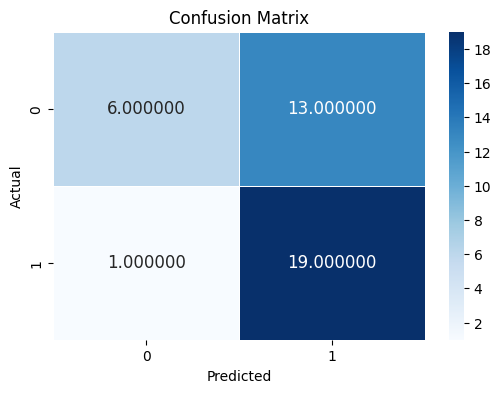

In [148]:
plt.figure(figsize=(6, 4))
sns.heatmap(model1Df["Confusion Matrix"][1], annot=True, fmt="f", cmap="Blues", linewidths=0.5, annot_kws={"size": 12})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

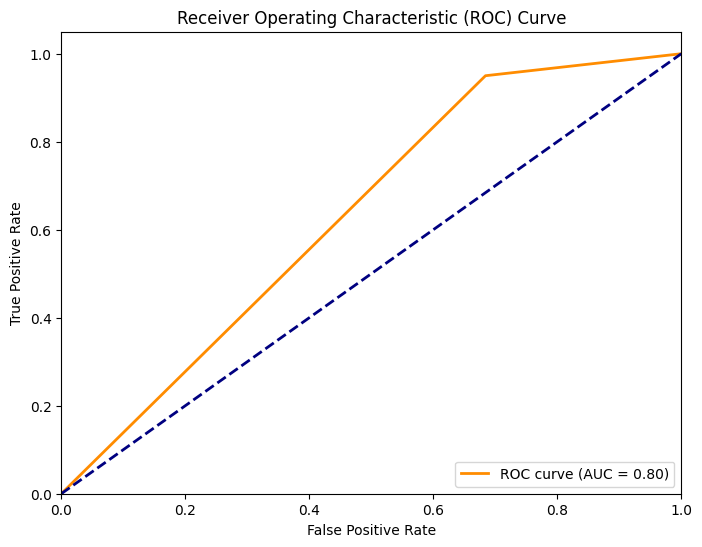

In [149]:
plt.figure(figsize=(8, 6))
plt.plot(fpr[1], tpr[1], color='darkorange', lw=2, label=f'ROC curve (AUC = {model1Df["AUC"][1]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


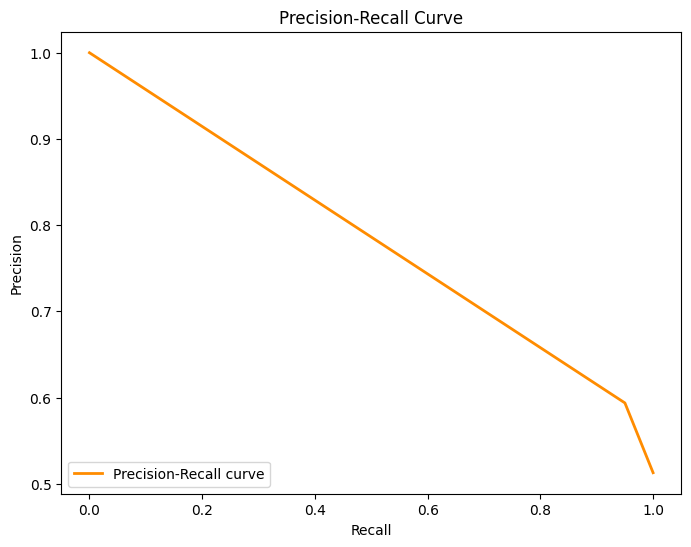

In [150]:
plt.figure(figsize=(8, 6))
plt.plot(recall[1], precision[1], color='darkorange', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


In [151]:
print(len(loss[1]))

11


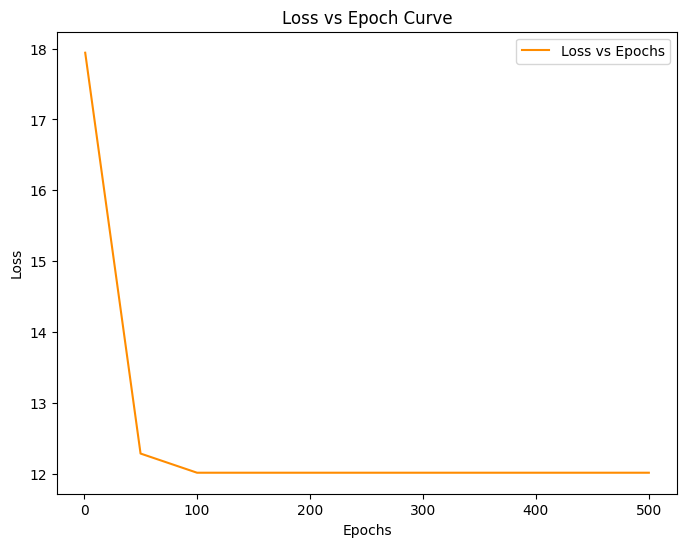

In [152]:
plt.figure(figsize=(8, 6))
plt.plot([1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500],loss[1], color='darkorange', label='Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epoch Curve')
plt.legend(loc='upper right')
plt.show()